# 1d3v electron hybrid code for R/L-waves with stationary ions and dipole background field

## 1. The model
The electron hybrid model for cold electrons with linearized fluid equations and hot kinetic electrons (Vlasov equation) reads

\begin{align}
&\frac{\partial\tilde{\mathbf{j}}_\mathrm{c}}{\partial t}=\epsilon_0\Omega_\mathrm{pe}^2\tilde{\mathbf{E}}+\tilde{\mathbf{j}}_\mathrm{c}\times\mathbf{\Omega}_\mathrm{ce}(\mathbf{x}),\\
&\frac{\partial f_\mathrm{h}}{\partial t}+\mathbf{v}\cdot\nabla f_\mathrm{h}+\frac{q_\mathrm{e}}{m_\mathrm{e}}(\mathbf{E}+\mathbf{v}\times\mathbf{B})\cdot\nabla_\mathbf{v}f_\mathrm{h}=0,\\
&\frac{\partial \tilde{\mathbf{B}}}{\partial t}=-\nabla\times\tilde{\mathbf{E}},\\
&\frac{1}{c^2}\frac{\partial \tilde{\mathbf{E}}}{\partial t}=\nabla\times\tilde{\mathbf{B}}-\mu_0\tilde{\mathbf{j}}_\mathrm{c}-\mu_0q_\mathrm{e}\int\mathbf{v}\tilde{f}_\mathrm{h}\,\mathrm{d}^3\mathbf{v},
\end{align}

where $\mathbf{\Omega}_\mathrm{ce}(\mathbf{x})=q_\mathrm{e}\mathbf{B}_0(\mathbf{x})/m_\mathrm{e}$ is the oriented electron cyclotron frequency corresponding to the background field $\mathbf{B}_0=\mathbf{B}_0(\mathbf{x})$ and $\Omega_{\mathrm{pe}}^2=n_{\mathrm{c}0}e^2/\epsilon_0m_\mathrm{e}$ the plasma frequency of the cold electrons. Here, only wave propagation parallel to the background magnetic field $\mathbf{B}_0=\mathbf{B}_0(\mathbf{x})$ is considered, i.e. $\textbf{k}=k\textbf{e}_z$. Therefore the nabla operator is simply $\nabla=\textbf{e}_z\partial_z$. The background magnetic field is a parabolically shaped.

We use homogeneous Dirichlet boundary conditions with a masking function for $(\tilde{E}_x,\tilde{E}_y,\tilde{j}_{\mathrm{c}x},\tilde{j}_{\mathrm{c}y})$ and no boundary conditions for $(\tilde{B}_x,\tilde{B}_y)$.

In [63]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

import psydac.core.interface as inter

import time

import utilitis_opt as utils_opt
import utilitis_pic


#====================================================================================
#  calling epyccel
#====================================================================================
from pyccel.epyccel import epyccel
utils_pic_fast = epyccel(utilitis_pic)
print('pyccelization of pic functions done!')
#====================================================================================



#===== saving data? (save = 1: yes, save = 0: no). If yes, name directory ===========
save = 0
title = 'test.txt' 
#====================================================================================



#===== save only every saving_step-th time step =====================================
saving_step = 1
#====================================================================================



#===== physical parameters ==========================================================
eps0 = 1.0                         # vacuum permittivity
mu0 = 1.0                          # vacuum permeability
c = 1.0                            # speed of light
qe = -1.0                          # electron charge
me = 1.0                           # electron mass
B0z = 1.0                          # minimum of background magnetic field in z-direction
wce = qe*B0z/me                    # electron cyclotron frequency
wpe = 2*np.abs(wce)                # cold electron plasma frequency
nuh = 2e-3                         # ratio of cold/hot electron densities (nh/nc)
nh = nuh*wpe**2                    # hot electron density
wpar = 0.1*c                       # parallel thermal velocity of energetic particles
wperp = 0.1*c                      # perpendicular thermal velocity of energetic particles

xi = 0.                            # inhomogeneity factor of background magnetic field

bcs_d = 1                          # damping of wave fields at boundaries? (1: yes, 0: no)
bcs_g = 1                          # field line dependence of initial distribution function? (1: yes, 0: no)
#====================================================================================



#===== initial conditions ===========================================================
k = 2.                             # wavenumber of initial wave field perturbations
amp = 1e-4                         # amplitude of initial wave field perturbations
eps = 0.                           # amplitude of spatial pertubation of initial distribution function 


Ex0 = lambda z : 0*z               # initial Ex
Ey0 = lambda z : 0*z               # initial Ey
Bx0 = lambda z : 0*z               # initial Bx
By0 = lambda z : 0*z               # initial By
jx0 = lambda z : 0*z               # initial jcx
jy0 = lambda z : 0*z               # initial jcy
#====================================================================================



#===== numerical parameters =========================================================
Lz = 80.                           # length of z-domain
Nel = 512                          # number of elements z-direction
T = 300                            # simulation time
dt = 0.05                          # time step
p = 3                              # degree of B-spline basis functions in V0
Np = np.int(1e5)                   # number of markers
control = 1                        # control variate for noise reduction? (1: yes, 0: no)
time_integr = 0                    # do time integration? (1 : yes, 0: no)

Ld = 0.05*Lz                       # length of damping region at each end
#====================================================================================









#====== create parameter list =======================================================
pa = np.zeros(1*(Nel + p - 1) + 5)

pa[0]  = eps0
pa[1]  = mu0
pa[2]  = c
pa[3]  = qe 
pa[4]  = me 
pa[5]  = B0z 
pa[6]  = wce 
pa[7]  = wpe 
pa[8]  = nuh 
pa[9]  = nh 
pa[10] = wpar 
pa[11] = wperp 
pa[12] = k  
pa[13] = amp 
pa[14] = eps 
pa[15] = Lz 
pa[16] = Nel 
pa[17] = T 
pa[18] = dt 
pa[19] = p 
pa[20] = Np
pa[21] = control
pa[22] = saving_step

pa[23] = xi
pa[24] = Ld

pa[29] = bcs_d
pa[30] = bcs_g
#====================================================================================



#===== discretization of spatial domain =============================================
dz   = Lz/Nel                                # element size
el_b = np.linspace(0, Lz, Nel + 1)           # element boundaries

Nbase0   = Nel + p                           # total number of basis functions in V0
Nbase0_0 = Nbase0 - 2                        # number of degrees of freedom in V1

Nbase1   = Nbase0 - 1                        # total number of basis functions in V1
Nbase1_0 = Nbase1                            # number of degrees of freedom in V1
#====================================================================================



#===== some diagnostic values =======================================================
Eh_eq = Lz*nh*me/2*(wpar**2 + 2*wperp**2)    # equilibrium energetic electron energy

en_E = np.array([])                          # electric field energy
en_B = np.array([])                          # magnetic field energy
en_C = np.array([])                          # cold plasma energy
en_H = np.array([])                          # energetic electron energy
#====================================================================================



#===== background field in z-direction ==============================================
B_background_z = lambda z : B0z*(1 + xi*(z - Lz/2)**2)
#====================================================================================



#===== initial energetic electron distribution function =============================
def fh0(z, vx, vy, vz):

    xiB = 1 - B0z/B_background_z(z)
    xiz = 1 + (wperp**2/wpar**2 - 1)*xiB*bcs_g

    return (1 + eps*np.cos(k*z))*nh/((2*np.pi)**(3/2)*wpar*wperp**2)*np.exp(-vz**2/(2*wpar**2) - xiz*(vx**2 + vy**2)/(2*wperp**2))
#====================================================================================



#===== Maxwellian for control variate ===============================================
maxwell = lambda vx, vy, vz : nh/((2*np.pi)**(3/2)*wpar*wperp**2)*np.exp(-vz**2/(2*wpar**2) - (vx**2 + vy**2)/(2*wperp**2))
#====================================================================================


#===== sampling distribution for initial markers ====================================
g_sampling = lambda vx, vy, vz : 1/((2*np.pi)**(3/2)*wpar*wperp**2)*np.exp(-vz**2/(2*wpar**2) - (vx**2 + vy**2)/(2*wperp**2))*1/Lz
#====================================================================================



#===== masking function to damp wave fields near boundaries =========================
def damp(z):

    if z <= Ld:
        return np.sin(np.pi*z/(2*Ld))
    elif z >= Lz - Ld:
        return np.sin(np.pi*(Lz - z)/(2*Ld))
    else:
        return 1.0
#====================================================================================



#===== spline knot vector, global mass matrices (in V0 and V1) and gradient matrix ==
Tz = inter.make_open_knots(p, Nbase0)*Lz
tz = Tz[1:-1]

M0, C0 = utils_opt.matrixAssembly_V0(p, Nbase0, Tz, False)
M1 = utils_opt.matrixAssembly_V1(p, Nbase0, Tz, False)
Mb = utils_opt.matrixAssembly_backgroundField(p, Nbase0, Tz, False, B_background_z)

G = utils_opt.GRAD_1d(p, Nbase0, False)

print('matrix assembly done!')
#====================================================================================



#===== reserve memory for unknowns ==================================================
ex = np.empty(Nbase0)
ey = np.empty(Nbase0)
bx = np.empty(Nbase1)
by = np.empty(Nbase1)
yx = np.empty(Nbase0)
yy = np.empty(Nbase0)

uj = np.empty(4*Nbase0_0 + 2*Nbase1_0)

z_old = np.empty(Np)
#====================================================================================



#===== initial coefficients with commuting projectors ===============================
ex[:] = utils_opt.PI_0_1d(Ex0, p, Nbase0, Tz, False)
ey[:] = utils_opt.PI_0_1d(Ey0, p, Nbase0, Tz, False)
bx[:] = utils_opt.PI_1_1d(Bx0, p, Nbase0, Tz, False)
by[:] = utils_opt.PI_1_1d(By0, p, Nbase0, Tz, False)
yx[:] = utils_opt.PI_0_1d(jx0, p, Nbase0, Tz, False)
yy[:] = utils_opt.PI_0_1d(jy0, p, Nbase0, Tz, False)

uj[:] = np.concatenate((ex[1:-1], ey[1:-1], bx, by, yx[1:-1], yy[1:-1]))

print('projection of initial fields done!')
#====================================================================================



#===== construct block matrices for field update ====================================
ZERO_00 = np.zeros((Nbase0_0, Nbase0_0))
ZERO_01 = np.zeros((Nbase0_0, Nbase1_0))
ZERO_11 = np.zeros((Nbase1_0, Nbase1_0))

A1 = np.diag(np.ones(4*Nbase0_0 + 2*Nbase1_0))

A1[0:Nbase0_0, 0:Nbase0_0] = M0
A1[Nbase0_0:2*Nbase0_0, Nbase0_0:2*Nbase0_0] = M0

A1[2*Nbase0_0 + 2*Nbase1_0:3*Nbase0_0 + 2*Nbase1_0, 2*Nbase0_0 + 2*Nbase1_0:3*Nbase0_0 + 2*Nbase1_0] = M0
A1[3*Nbase0_0 + 2*Nbase1_0:4*Nbase0_0 + 2*Nbase1_0, 3*Nbase0_0 + 2*Nbase1_0:4*Nbase0_0 + 2*Nbase1_0] = M0

A2 = np.block([[ZERO_00, ZERO_00, ZERO_01, c**2*np.dot(G.T, M1), -mu0*c**2*M0, ZERO_00], [ZERO_00, ZERO_00, -c**2*np.dot(G.T, M1), ZERO_01, ZERO_00, -mu0*c**2*M0], [ZERO_01.T, G, ZERO_11, ZERO_11, ZERO_01.T, ZERO_01.T], [-G, ZERO_01.T, ZERO_11, ZERO_11, ZERO_01.T, ZERO_01.T], [eps0*wpe**2*M0, ZERO_00, ZERO_01, ZERO_01, ZERO_00, qe/me*Mb], [ZERO_00, eps0*wpe**2*M0, ZERO_01, ZERO_01, -qe/me*Mb, ZERO_00]])

LHS = sc.sparse.csc_matrix(A1 - 1/2*dt*A2)
RHS = sc.sparse.csc_matrix(A1 + 1/2*dt*A2)

LU = sc.sparse.linalg.splu(LHS)

print('LU factorization done!')


if bcs_d == 1:
    grev = inter.compute_greville(p, Nbase0, Tz)
    coll = inter.collocation_matrix(p, Nbase0, Tz, grev)[1:-1, 1:-1]
    gi = np.zeros(Nbase0)

    for i in range(Nbase0):
        gi[i] = damp(grev[i])

    Gi = np.diag(gi[1:-1])

    DAMP = np.dot(np.dot(np.linalg.inv(coll), Gi), coll)
else:
    DAMP = np.identity(Nbase0_0)
    
DAMP_block = sc.linalg.block_diag(DAMP, DAMP, np.identity(Nbase1_0), np.identity(Nbase1_0), DAMP, DAMP)
    
print('damping assembly done!')
#====================================================================================



#===== create particles (z,vx,vy,vz,wk) and sample according to sampling distribution
particles = np.zeros((Np, 5), order='F')
particles[:, 0] = np.random.rand(Np)*Lz
particles[:, 1] = np.random.randn(Np)*wperp
particles[:, 2] = np.random.randn(Np)*wperp
particles[:, 3] = np.random.randn(Np)*wpar

jh = np.zeros(2*Nbase0)
Fh = np.zeros(4*Nbase0_0 + 2*Nbase1_0)
#====================================================================================



#===== parameters for control variate ===============================================
g0 = g_sampling(particles[:, 1], particles[:, 2], particles[:, 3])
w0 = fh0(particles[:, 0], particles[:, 1], particles[:, 2], particles[:, 3])/g_sampling(particles[:, 1], particles[:, 2], particles[:, 3])
#====================================================================================



#===== initialize velocities by pushing back by -dt/2 and compute weights ===========
timea = time.time()

z_old[:] = particles[:, 0]

utils_pic_fast.borisGem_bc_2(particles, -dt/2, qe, me, Tz, tz, p, ex, ey, bx, by, B0z, xi, Lz)

particles[:, 0] = z_old
particles[:, 4] = w0 - control*maxwell(particles[:, 1], particles[:, 2], particles[:, 3])/g0

timeb = time.time()
print('time for particle push: ' + str(timeb - timea))
#====================================================================================



#===== test timing for hot current computation ======================================
timea = time.time()

utils_pic_fast.hotCurrent_bc_2(particles[:, 1:3], particles[:, 0], particles[:, 4], Tz, p, qe, jh)

timeb = time.time()
print('time for hot current computation: ' + str(timeb - timea))
#====================================================================================



#===== test timing for linear solver ================================================
timea = time.time()

LU.solve(RHS.dot(uj) + dt*Fh)

timeb = time.time()
print('time for solving linear system: ' + str(timeb - timea))
#====================================================================================



#===== time integration by a time step dt ===========================================
def update():
    
    
    # ... save old positions
    z_old[:] = particles[:, 0]
    # ...
    
    
    # ... update particle velocities from n-1/2 to n+1/2 with fields at time n and positions from n to n+1 with velocities at n+1/2
    utils_pic_fast.borisGem_bc_2(particles, dt, qe, me, Tz, tz, p, ex, ey, bx, by, B0z, xi, Lz)
    # ...
    
    
    # ... update weights with control variate
    particles[:, 4] = w0 - control*maxwell(particles[:, 1], particles[:, 2], particles[:, 3])/g0
    # ...
    
    
    # ... compute hot electron current densities
    utils_pic_fast.hotCurrent_bc_2(particles[:, 1:3], 1/2*(z_old + particles[:, 0]), particles[:, 4], Tz, p, qe, jh)
    # ...
     
    
    # ... assemble right-hand side of weak formulation
    Fh[:Nbase0_0] = -c**2*mu0*jh[2:-2][0::2]
    Fh[Nbase0_0:2*Nbase0_0] = -c**2*mu0*jh[2:-2][1::2]
    # ...
    
    
    # ... time integration of E, B, jc from n to n+1 with Crank-Nicolson method (use hot current density at n+1/2) 
    uj[:] = np.dot(DAMP_block, LU.solve(RHS.dot(uj) + dt*Fh))
       
    ex[:] = np.array([0] + list(uj[:Nbase0_0]) + [0])
    ey[:] = np.array([0] + list(uj[Nbase0_0:2*Nbase0_0]) + [0])
    bx[:] = uj[2*Nbase0_0:2*Nbase0_0 + Nbase1_0]
    by[:] = uj[2*Nbase0_0 + Nbase1_0:2*Nbase0_0 + 2*Nbase1_0]
    yx[:] = np.array([0] + list(uj[2*Nbase0_0 + 2*Nbase1_0:3*Nbase0_0 + 2*Nbase1_0]) + [0])
    yy[:] = np.array([0] + list(uj[3*Nbase0_0 + 2*Nbase1_0:4*Nbase0_0 + 2*Nbase1_0]) + [0])
    # ...
#====================================================================================



#===== create data file and save parameters (first row), initial fields and energies (second row)
if save == 1:
    file = open(title, 'ab')
    np.savetxt(file, np.reshape(pa, (1, 1*Nbase1_0 + 5)), fmt = '%1.10e')


en_E = np.append(en_E, eps0/2*(np.dot(ex[1:-1], np.dot(M0, ex[1:-1])) + np.dot(ey[1:-1], np.dot(M0, ey[1:-1]))))
en_B = np.append(en_B, eps0/(2*mu0)*(np.dot(bx, np.dot(M1, bx)) + np.dot(by, np.dot(M1, by))))
en_C = np.append(en_C, 1/(2*eps0*wpe**2)*(np.dot(yx[1:-1], np.dot(M0, yx[1:-1])) + np.dot(yy[1:-1], np.dot(M0, yy[1:-1]))))
en_H = np.append(en_H, me/(2*Np)*np.dot(particles[:, 4], particles[:, 1]**2 + particles[:, 2]**2 + particles[:, 3]**2) + control*Eh_eq)

bx_save = np.copy(bx)

if save == 1:
    data = np.append(bx, np.array([en_E[-1], en_B[-1], en_C[-1], en_H[-1], 0.]))
    np.savetxt(file, np.reshape(data, (1, 1*Nbase1_0 + 5)), fmt = '%1.10e')
#====================================================================================



#===== time integration =============================================================
if time_integr == 1:

    print('start time integration! (number of time steps : ' + str(int(T/dt)) + ')')
    time_step = 0

    while True:

        try:
            if time_step*dt >= T:
                if save == 1:
                    file.close()
                break

            if time_step%50 == 0:
                print('time steps finished: ' + str(time_step))

            update()

            if time_step%saving_step == 0:

                # ... add data to file
                en_E = np.append(en_E, eps0/2*(np.dot(ex[1:-1], np.dot(M0, ex[1:-1])) + np.dot(ey[1:-1], np.dot(M0, ey[1:-1]))))
                en_B = np.append(en_B, eps0/(2*mu0)*(np.dot(bx, np.dot(M1, bx)) + np.dot(by, np.dot(M1, by))))
                en_C = np.append(en_C, 1/(2*eps0*wpe**2)*(np.dot(yx[1:-1], np.dot(M0, yx[1:-1])) + np.dot(yy[1:-1], np.dot(M0, yy[1:-1]))))
                en_H = np.append(en_H, me/(2*Np)*np.dot(particles[:, 4], particles[:, 1]**2 + particles[:, 2]**2 + particles[:, 3]**2) + control*Eh_eq)

                bx_save = np.vstack((bx_save, np.copy(bx)))
                
                if save == 1:
                    data = np.append(bx, np.array([en_E[-1], en_B[-1], en_C[-1], en_H[-1], (time_step + 1)*dt]))
                    np.savetxt(file, np.reshape(data, (1, 1*Nbase1_0 + 5)), fmt = '%1.10e')
                # ...

            time_step += 1
        except KeyboardInterrupt:
            print('Pausing...  (Hit ENTER to continue, type quit to exit.)')
            
            if save == 1:
                file.close()
            
            try:
                response = input()
                if response == 'quit':
                    break
                print('Resuming...')
                
                if save == 1:
                    file = open(title, 'ab')
                
            except KeyboardInterrupt:
                print('Resuming...')
                
                if save == 1:
                    file = open(title, 'ab')
                
                continue
                
    if save == 1:
        file.close()
#====================================================================================

pyccelization of pic functions done!
matrix assembly done!
projection of initial fields done!
LU factorization done!
damping assembly done!
time for particle push: 0.06228017807006836
time for hot current computation: 0.01919722557067871
time for solving linear system: 0.0010533332824707031


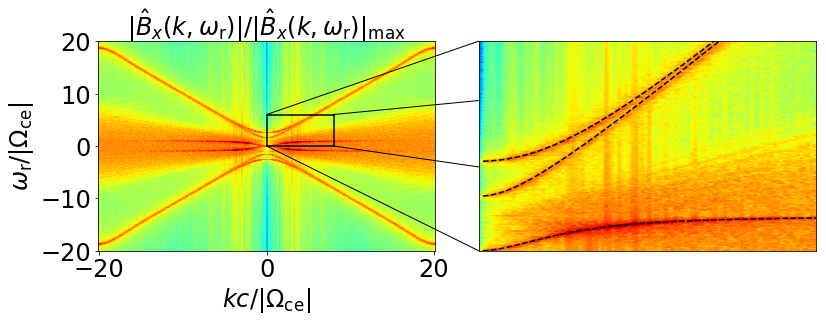

In [2]:
from matplotlib.colors import LogNorm
from matplotlib.patches import ConnectionPatch

Nt = len(en_B) - 1

f3 = plt.figure()
f3.set_figheight(5)
f3.set_figwidth(12)

fontsize = 24
#plt.rc('text', usetex = False)
#plt.rc('font', family = 'serif')
plt.rcParams.update({'font.size': fontsize})
plt.rc('xtick', labelsize = fontsize)
plt.rc('ytick', labelsize = fontsize)

w = np.linspace(0, Nt, Nt + 1) - Nt/2
w = 2*np.pi/T*w

ks = np.linspace(0, Nbase1_0 - 1, Nbase1_0) - (Nbase1_0 - 1)/2
ks = 2*np.pi/Lz*ks

Bxkw = np.fft.fft2(bx_save)
K, W = np.meshgrid(ks, w)
Bkw = np.fft.fftshift(Bxkw)
Bkw_plot = np.abs(Bkw)



ax1 = plt.subplot(121)

ticks = np.power(10, np.linspace(-8, 0, 5))
lvls = np.logspace(-8, 0, 60)
plt.contourf(K, W, Bkw_plot/Bkw_plot.max(), cmap = 'jet', norm = LogNorm(), levels = lvls)
plt.plot(np.linspace(0, 8, 10), np.zeros(10), 'k')
plt.plot(np.linspace(0, 8, 10), np.ones(10)*6, 'k')
plt.plot(np.zeros(10), np.linspace(0, 6, 10), 'k')
plt.plot(np.ones(10)*8, np.linspace(0, 6, 10), 'k')
plt.ylim((-20, 20))
plt.xlabel(r'$kc/ |\Omega_\mathrm{ce}|$')
plt.ylabel(r'$\omega_\mathrm{r}/ |\Omega_\mathrm{ce}|$')
plt.title(r'$|\hat{B}_x(k,\omega_\mathrm{r})|/|\hat{B}_x(k,\omega_\mathrm{r})|_\mathrm{max}$', fontsize = fontsize)




# ... analytical dispersion relation
k1 = np.linspace(0.1, 8.0, 40)

w1_1 = np.zeros(40)
w1_2 = np.zeros(40)
w1_3 = np.zeros(40)

w1_1[0] = 0.0001 
w1_2[0] = 1.5001 
w1_3[0] = 2.5001


for i in range(0, 40):
    
    if i == 0:
        w1_1[i] = utils_opt.solveDispersionCold(k1[i], +1, c, wce, wpe, w1_1[i], 1e-6, 100)[0]
        w1_2[i] = utils_opt.solveDispersionCold(k1[i], -1, c, wce, wpe, w1_2[i], 1e-6, 100)[0]
        w1_3[i] = utils_opt.solveDispersionCold(k1[i], +1, c, wce, wpe, w1_3[i], 1e-6, 100)[0]
    
    else:
        w1_1[i] = utils_opt.solveDispersionCold(k1[i], +1, c, wce, wpe, w1_1[i-1], 1e-6, 100)[0]
        w1_2[i] = utils_opt.solveDispersionCold(k1[i], -1, c, wce, wpe, w1_2[i-1], 1e-6, 100)[0]
        w1_3[i] = utils_opt.solveDispersionCold(k1[i], +1, c, wce, wpe, w1_3[i-1], 1e-6, 100)[0]
# ...    

    
    
ax2 = plt.subplot(122)   

ticks = np.power(10, np.linspace(-8, 0, 5))
lvls = np.logspace(-8, 0, 60)
plt.contourf(K, W, Bkw_plot/Bkw_plot.max(), cmap = 'jet', norm = LogNorm(), levels = lvls)
plt.xlim((0, 8))
plt.ylim((0, 6))
plt.xticks([], [])
plt.yticks([], [])
plt.plot(k1, w1_1, 'k--')
plt.plot(k1, w1_2, 'k--')
plt.plot(k1, w1_3, 'k--')
plt.subplots_adjust(hspace = 0.3)
plt.tight_layout()


con1 = ConnectionPatch(xyA = (0, 6), xyB = (0, 6), coordsA = "data", coordsB = "data", axesA = ax2, axesB = ax1, color = "black", linewidth = 1)
con2 = ConnectionPatch(xyA = (0, 0), xyB = (0, 0), coordsA = "data", coordsB = "data", axesA = ax2, axesB = ax1, color = "black", linewidth = 1)
con3 = ConnectionPatch(xyA = (0, 4.3), xyB = (8, 6), coordsA = "data", coordsB = "data", axesA = ax2, axesB = ax1, color = "black", linewidth = 1)
con4 = ConnectionPatch(xyA = (0, 2.4), xyB = (8, 0), coordsA = "data", coordsB = "data", axesA = ax2, axesB = ax1, color = "black", linewidth = 1)

ax2.add_artist(con1)
ax2.add_artist(con2)
ax2.add_artist(con3)
ax2.add_artist(con4)

#plt.title('B-splines: Strang', fontsize = fontsize)
#plt.savefig('Bsplines_Strang_spectrum.png', bbox_inches = 'tight')

In [3]:
data = np.loadtxt('test.txt')

In [4]:
en_H = data[1:, -2]
en_C = data[1:, -3]
en_B = data[1:, -4]
en_E = data[1:, -5]

en_tot = en_H + en_C + en_B + en_E

Nt = len(en_B) - 1

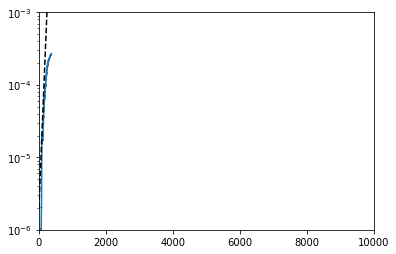

In [62]:
tn = np.linspace(0., Nt*0.1, Nt + 1)
plt.semilogy(tn, en_B/327.7)
plt.xlim((0, 10000))
plt.ylim((1e-6, 1e-3))

t2 = np.linspace(0, 550, 100) 
plt.semilogy(t2, 2e-6*np.exp(gamma*2*t2), 'k--', label = 'expected growth')

In [57]:
omega = utils_opt.solveDispersionHybrid(2.88, +1, c, wce, 5.0, 0.2, 0.53, 6e-3, 0.25 + 0j, 1e-8)[0]
omega_r = np.real(omega)
gamma = np.imag(omega)

In [58]:
100*gamma

1.2965398116017401

In [59]:
omega_r

0.2467654207197003

In [134]:
Lz = 6.

# ... unit test boris pusher
test_particle = np.zeros((2, 5), order='F')

test_particle[:, 0] = Lz/2 - 2.62 
test_particle[:, 1] = 0.117
test_particle[:, 3] = 0.0795

xi_test = 0.862

Nt = int(150/0.05)

tn = np.linspace(0., 150., Nt + 1)

ex = np.zeros(Nbase0)
ey = np.zeros(Nbase0)
bx = np.zeros(Nbase1)
by = np.zeros(Nbase1)

z_old = np.copy(test_particle[:, 0])
utils_pic_fast.borisGem_bc_2(test_particle, -0.05/2, qe, me, Tz, tz, p, ex, ey, bx, by, B0z, xi_test, Lz)
test_particle[:, 0] = z_old

positions = np.empty(Nt + 1)
positions[0] = test_particle[0, 0]

for i in range(Nt):
    utils_pic_fast.borisGem_bc_2(test_particle, 0.05, qe, me, Tz, tz, p, ex, ey, bx, by, B0z, xi_test, Lz)
    positions[i + 1] = test_particle[0, 0]
# ...

(-1.0, 9.0)

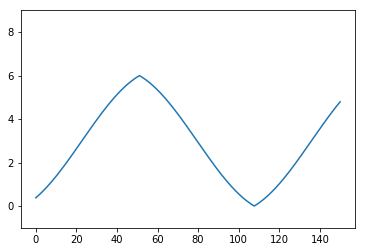

In [135]:
plt.plot(tn, positions)
plt.ylim((Lz/2 - 4, Lz/2 + 6))

In [121]:
utils_pic_fast.borisGem_bc_2(test_particle, -0.05/2, qe, me, Tz, tz, p, ex, ey, bx, by, B0z, xi_test, Lz)

In [129]:
Lz/2

40.0

In [ ]:
positions = np.empty(Nt + 1)
positions[0] = test_particle[0, 0]

for i in range(Nt):
    utils_pic_fast.borisGem_bc_2(test_particle, 0.05, qe, me, Tz, tz, p, ex, ey, bx, by, B0z, xi_test, Lz)
    positions[i + 1] = test_particle[0, 0]

In [114]:
#===== create particles (z,vx,vy,vz,wk) and sample according to sampling distribution
particles = np.zeros((Np, 5), order='F')
particles[:, 0] = np.random.rand(Np)*Lz
particles[:, 1] = np.random.randn(Np)*wperp
particles[:, 2] = np.random.randn(Np)*wperp
particles[:, 3] = np.random.randn(Np)*wpar

jh = np.zeros(2*Nbase0)
Fh = np.zeros(4*Nbase0_0 + 2*Nbase1_0)
#====================================================================================

In [115]:
particles

array([[ 1.59501960e+01, -7.94598199e-02, -8.68842972e-02,
         1.48600712e-01,  0.00000000e+00],
       [ 7.30232762e+01, -1.59200368e-01, -5.20397069e-02,
        -2.28070448e-01,  0.00000000e+00],
       [ 4.25806022e+01,  7.21874288e-02, -6.84479791e-02,
        -2.89051226e-01,  0.00000000e+00],
       ...,
       [ 4.23779316e+01, -9.42737722e-02,  1.15407924e-01,
         8.70262568e-02,  0.00000000e+00],
       [ 1.47377768e+01,  5.31137458e-02, -5.21829891e-02,
         2.07025697e-02,  0.00000000e+00],
       [ 1.17286290e+00, -1.15241720e-01, -1.56943584e-01,
         1.10182482e-01,  0.00000000e+00]])

In [116]:
utils_pic_fast.borisGem_bc_2(particles, -dt/2, qe, me, Tz, tz, p, ex, ey, bx, by, B0z, xi, Lz)

In [118]:
particles

array([[ 1.59464810e+01, -8.16067607e-02, -8.48709650e-02,
         1.48600712e-01,  0.00000000e+00],
       [ 7.30289780e+01, -1.60451415e-01, -4.80440596e-02,
        -2.28070448e-01,  0.00000000e+00],
       [ 4.25878285e+01,  7.04539416e-02, -7.02309962e-02,
        -2.89051226e-01,  0.00000000e+00],
       ...,
       [ 4.23757560e+01, -9.13595689e-02,  1.17728341e-01,
         8.70262568e-02,  0.00000000e+00],
       [ 1.47372592e+01,  5.17927795e-02, -5.34943206e-02,
         2.07025697e-02,  0.00000000e+00],
       [ 1.17010834e+00, -1.19128689e-01, -1.54013954e-01,
         1.10182482e-01,  0.00000000e+00]])